<a href="https://colab.research.google.com/github/dotsnangles/from-keras-to-pytorch/blob/main/pneumonia_detection_using_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 데이터를 다운로드합니다.
- 캐글에 계정을 생성한 후 kaggle.json을 생성하여 아래의 코드를 순서대로 실행합니다.

In [ ]:
from google.colab import files
files.upload()         # expire any previous token(s) and upload recreated token

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"leejongmin1st","key":"e0e3183181e8ffb7cd7553dd975b5b10"}'}

In [1]:
# !rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets list

In [2]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
 99% 2.27G/2.29G [00:21<00:00, 190MB/s]
100% 2.29G/2.29G [00:21<00:00, 115MB/s]


In [3]:
!mkdir -p /content/input/chest-xray-pneumonia
!unzip -q /content/chest-xray-pneumonia.zip -d /content/input/chest-xray-pneumonia

# 폐렴이란 무엇인가요?
- 폐렴은 폐포라고 알려진 작은 공기주머니에 주로 영향을 미치는 폐의 염증 상태입니다.증상은 일반적으로 습성적이거나나 건조한 기침, 가슴 통증, 발열, 호흡 곤란 등의 조합을 포함하며, 상태의 심각도는 가변적입니다.
- 폐렴은 일반적으로 바이러스나 박테리아에 감염되어 발생하며, 다른 미생물, 특정 약물 또는 자가면역질환과 같은 조건에 의해 발생하는 경우는 드물다고 알려져 있습니다.
- 관련 위험 인자로는 낭포성 섬유증, 만성 폐쇄성 폐질환(COPD), 천식, 당뇨병, 심부전, 흡연 이력, 뇌졸중과 같은 기침 능력 저하, 면역 체계 약화 등이 있으며, 진단은 보통 증상과 신체 검사를 기반으로 합니다. 흉부 엑스레이, 혈액 검사, 가래 배양 등이 진단 확인에 도움이 될 수 있습니다.
- 폐렴은 지역사회 또는 병원에서 획득한 폐렴이나 의료 관련 폐렴과 같이 감염된 위치에 따라 분류될 수도 있습니다.
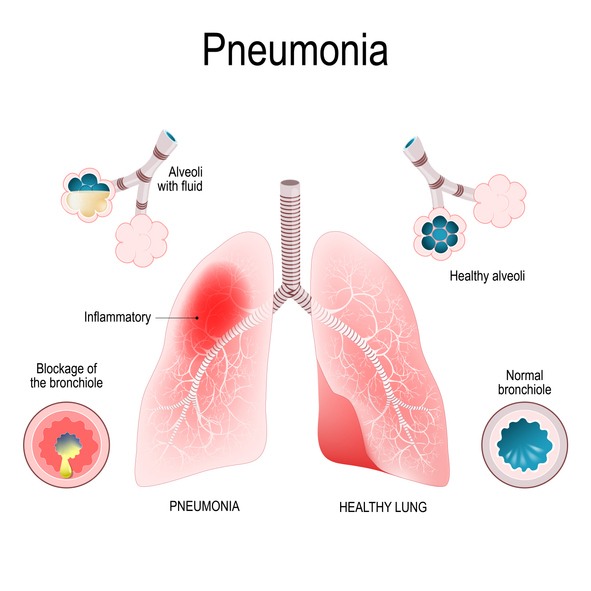

# 필요한 라이브러리들을 import 해줍니다.

In [4]:
import random
import time
import os

import numpy as np
import pandas as pd
import cv2 # OpenCV

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset

import torchvision
import torchvision.transforms as transforms

from skimage.feature import hog
from sklearn.decomposition import PCA

from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# 폐렴 데이터 세트

- 데이터 세트는 3개의 폴더(Train, test, val)로 구성되며 각 영상 범주(Pneumonia/Normal)에 대한 하위 폴더가 포함됩니다. 5,863개의 X선 영상(JPEG)과 2개의 범주(폐렴/정상)가 있습니다.
- 흉부 X선 영상(앞-뒤)은 광저우 여성 및 어린이 의료 센터의 1~5세 소아 환자의 회고적 코호트에서 선택되었습니다. 모든 흉부 X선 촬영은 환자의 일상적인 임상 치료의 일환으로 수행되었습니다.
- 흉부 X선 영상 분석을 위해 모든 흉부 방사선 사진은 처음에 저품질 또는 판독 불가능한 스캔을 모두 제거하여 품질 관리를 위해 선별되었으며, 이미지에 대한 진단은 AI 시스템 훈련을 위해 승인되기 전에 두 명의 전문 의사에 의해 등급이 매겨졌습니다. 채점 오류를 설명하기 위해, 평가 세트는 또한 세 번째 전문가에 의해 확인되었습니다.

## 다운로드한 데이터 세트의 각 샘플을 모델 훈련을 위해 일정한 크기로 변환하여 불러옵니다.
- 라벨 또한 'PNEUMONIA'는 0, 'NORMAL'은 1로 변환해줍니다.

In [5]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)

    return data

정의한 함수를 적용하여 훈련 / 검증 / 시험 데이터를 불러옵니다.  
훈련 데이터와 검증 데이터의 비율을 맞추기 위해 시험 데이터를 검증 데이터로 사용합니다.

In [ ]:
train = get_training_data('/content/input/chest-xray-pneumonia/chest_xray/train')
val = get_training_data('/content/input/chest-xray-pneumonia/chest_xray/val')
test = get_training_data('/content/input/chest-xray-pneumonia/chest_xray/test')

In [ ]:
len(train), len(val), len(test)

In [ ]:
print(train[0][1])

## 훈련 데이터의 범주는 폐렴과 정상 두 가지로 이진 분류 모델을 위한 것입니다.
- 시각화를 통해 그 분포를 살펴봅니다.

([<matplotlib.axis.XTick at 0x7d2c078ae0e0>,
 [Text(0, 0, 'PNEUMONIA'), Text(1, 0, 'NORMAL')])

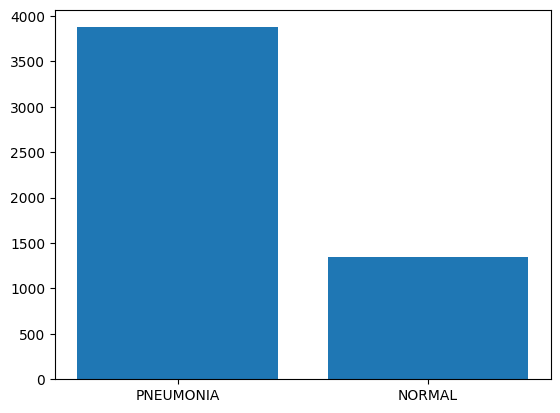

In [ ]:
num_pne = 0
num_nor = 0
for i in train:
    if(i[1] == 0):
        num_pne += 1
    else:
        num_nor += 1

x = np.arange(2)
num_list = [num_pne, num_nor]
label = ["PNEUMONIA", "NORMAL"]

plt.bar(x, num_list)
plt.xticks(x, label)

훈련 데이터의 비율이 불균형하다는 것을 확인할 수 있습니다. 데이터 불균형은 모델의 과적합으로 이어집니다.  
이를 극복하기 위해 추후 Normal 데이터를 증식하는 작업을 수행할 것입니다.

각 클래스의 이미지 샘플을 살펴봅니다.  
폐렴 환자의 엑스레이 이미지와 정상인의 엑스레이 이미지가 상이함을 확인할 수 있습니다.

Text(0.5, 1.0, 'NORMAL')

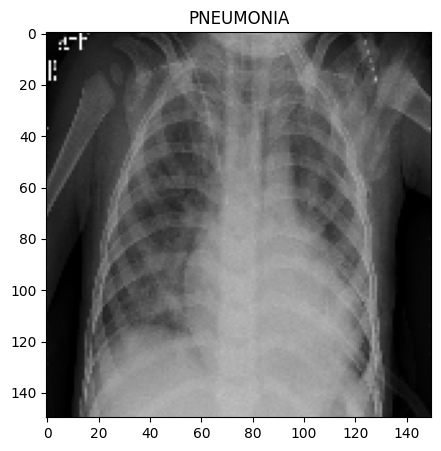

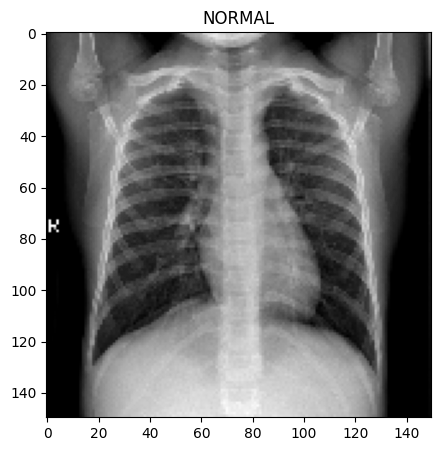

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

## 이미지와 라벨을 각각 x와 y로 나눠줍니다.
- x의 집합은 모델의 입력값이 되며 y의 집합은 모델의 출력값이 됩니다.

In [ ]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

In [ ]:
print(len(x_train))
print(len(y_train))
print(len(x_test))

5216
5216
624


라벨을 넘파이 배열로 변환합니다

In [ ]:
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

## 그레이스케일 정규화

- 이미지별 조도의 차이를 줄이고 CNN 모델의 수렴 속도를 증가시키기 위해 greyscale normalization을 수행합니다.
- 노멀라이제이션을 마친 데이터는 0과 1사이의 값을 갖게 됩니다.
- ([0..255] -> [0..1])

x 데이터에 정규화 작업을 수행합니다.

In [ ]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
x_train[0].shape

(150, 150)

## 데이터 증식
- 데이터 증식이란 과적합 문제를 피하기 위해 데이터 세트를 인위적으로 확장하는 기술을 뜻합니다.
- 라벨을 동일하게 유지하면서 어레이 표현을 변경하는 방식으로 학습 데이터를 증식할 수 있습니다.
- 자주 쓰이는 이미지 데이터 증식 기법에는 그레이스케일, 수평 플립, 수직 플립, 무작위 크롭, 컬러 변화, 이동, 회전 등이 있습니다.
- 이러한 변환 방법 중 몇 가지를 훈련 데이터에 적용하면 쉽게 훈련 데이터의 수를 늘려 보다 강력한 모델을 만들 수 있습니다.

훈련 데이터는 총 5216개로 구성되어 있습니다.

In [ ]:
len(x_train), len(y_train)

(5216, 5216)

그 중 폐렴에 해당하는 샘플은 3875개이며, 정상에 해당하는 샘플은 1341로 그 차이는 2534개입니다.

In [ ]:
len(x_train[y_train == 0]), len(x_train[y_train == 1]), len(x_train[y_train == 0]) - len(x_train[y_train == 1])

(3875, 1341, 2534)

샘플을 증식하여 데이터 불균형 문제를 어느 정도 해소할 수 있습니다.

적용하려는 증식 기법은 아래 주석과 같습니다.  
torchvision.transforms의 클래스를 조합하여 사용합니다.

In [ ]:
# Randomly rotate some training images by 30 degrees
# Randomly Zoom by 20% some training images
# Randomly shift images horizontally by 10% of the width
# Randomly shift images vertically by 10% of the height
# Randomly flip images horizontally. Once our model is ready, we fit the training dataset.

rotate = transforms.RandomRotation(30)
zoom = transforms.RandomResizedCrop(150, scale=(0.8, 1.0), ratio=[1.0, 1.0])
hshift = transforms.RandomAffine(0, translate=[0.1, 0])
vshift = transforms.RandomAffine(0, translate=[0, 0.1])
hflip = transforms.RandomHorizontalFlip(p=0.5)

transform_pipe = transforms.Compose([
    rotate, zoom, hshift, vshift, hflip
])

transform_lst = [
    rotate, zoom, hshift, vshift, hflip
]

In [ ]:
def show_images(images):
    num_images = len(images)
    cols = min(5, num_images)
    rows = (num_images - 1) // cols + 1

    plt.figure(figsize=(10, 4))
    gs = GridSpec(rows, cols)

    for i, image in enumerate(images):
        ax = plt.subplot(gs[i])
        ax.imshow(image, cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

원본 데이터와 증식 데이터의 차이를 확인합니다.

original images


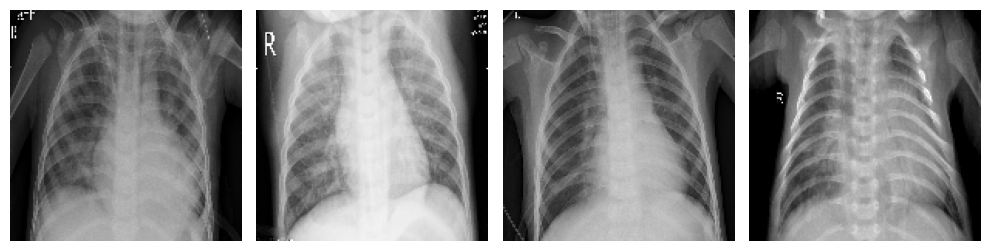


transformed images


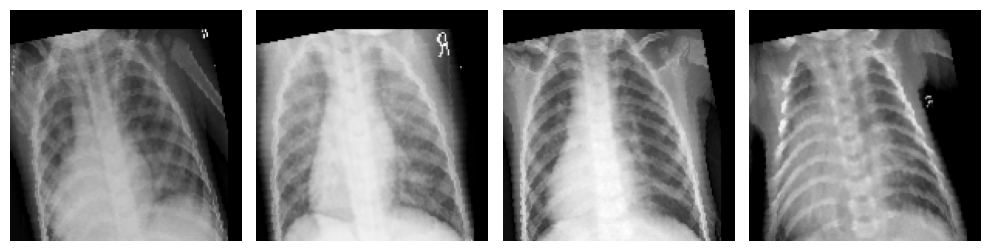

In [ ]:
make_grid = torchvision.utils.make_grid

imgs = torch.Tensor(x_train[:4])
transformed_img = transform_pipe(imgs)

print('original images')
show_images(imgs)

print('\ntransformed images')
show_images(transformed_img)

정상 샘플만 증식할지 전체 샘플을 모두 증식할지 여부를 결정합니다.

In [ ]:
# 정상 샘플만 증식
targets = x_train[y_train == 1]
labels = y_train[y_train == 1]
difference = len(x_train[y_train == 0]) - len(x_train[y_train == 1])
num_aug = int(difference / 3)

# # 전체 샘플 증식
# targets = x_train
# labels = y_train
# num_aug = len(targets)

증식 기법 활용 방안을 선택한 후 증식 데이터를 생성합니다.

In [ ]:
# select_one이 True일 때는 샘플 당 하나의 증식 기법만 무작위로 선택되어 적용됩니다.
select_one = True

transformed = None
labels4aug = []
for _ in range(num_aug):
    idx = random.randint(0, len(targets) - 1)
    sample = torch.Tensor(targets[idx]).unsqueeze(0)

    if select_one:
        aug_idx = random.randint(0, len(transform_lst) - 1)
        transform_pipe = transform_lst[aug_idx]

    if type(transformed) == type(None):
        transformed = transform_pipe(sample).numpy()
    else:
        transformed = np.concatenate((transformed, transform_pipe(sample).numpy()), axis=0)

    labels4aug.append(labels[idx])
labels4aug = np.array(labels4aug, dtype='int64')

In [ ]:
transformed.shape, labels4aug.shape


((844, 150, 150), (844,))

증식 데이터가 정상적으로 생성되었는지 확인합니다.

In [ ]:
make_grid = torchvision.utils.make_grid

imgs = torch.Tensor(transformed[:4])

print('transformed images')
# imshow(make_grid(transformed_img))

transformed images


증식 데이터와 원본 데이터 concat 여부를 결정한 뒤 train 데이터의 증식을 마무리합니다.

In [ ]:
# concatenate original and transformed
x_train_augged = np.concatenate((x_train, transformed), axis=0)
y_train_augged = np.concatenate((y_train, labels4aug), axis=0)

# # no concatenation
# x_train_augged = transformed
# y_train_augged = labels4aug

In [ ]:
print(x_train_augged.shape)
print(y_train_augged.shape)

(6060, 150, 150)
(6060,)


## 이미지를 다양한 방법으로 벡터화하고 벡터화된 이미지를 MLP, SVC, RandomForestClassifier 모델로 학습하고 평가합니다.

* MLP : 단층 퍼셉트론의 형태에서 은닉층이 1개 이상 추가된 신경망을 다층 퍼셉트론(MLP)이라고 합니다.
* SVC : 데이터를 선형으로 분리하는 지도 학습 모델이며 비선형의 경우 차원을 늘려 선형으로 분리합니다.
* RandomForestClassifier : 기계 학습에서의 랜덤 포레스트(영어: random forest)는 분류, 회귀 분석 등에 사용되는 앙상블 학습 방법의 일종으로, 훈련 과정에서 구성한 다수의 결정 트리로부터 부류(분류) 또는 평균 예측치(회귀 분석)를 출력함으로써 동작합니다

평가지표를 출력할 함수를 정의합니다

In [ ]:
def caculate_metrics(model, x_test, y_test):

    # 모델 예측
    predictions = model.predict(x_test)

    # Precision
    precision = precision_score(y_test, predictions, average='binary')
    print(f'Precision: {precision}')

    # Recall
    recall = recall_score(y_test, predictions, average='binary')
    print(f'Recall: {recall}')

    # F1-score
    f1 = f1_score(y_test, predictions, average='binary')
    print(f'F1-score: {f1}')

    # Accuracy
    accuracy = accuracy_score(y_test, predictions)
    print(f'Accuracy: {accuracy}')

### 이미지를 1차원 배열로 변환하여 MLP, SVC, RandomForestClassifier 모델로 평가합니다.
---

이미지를 1차원으로 flatten 합니다.

In [ ]:
x_train_flattened = []
for image in x_train_augged:
    image_vector = np.reshape(image, -1)
    x_train_flattened.append(image_vector)

x_test_flattened = []
for image in x_test:
    image_vector = np.reshape(image, -1)
    x_test_flattened.append(image_vector)

print(x_train_flattened[0].shape)
print(x_test_flattened[0].shape)

(22500,)
(22500,)


sklearn의 MLPClassifier를 사용하여 벡터화한 이미지를 학습하고 평가합니다.

In [ ]:
# MLP 모델 생성
model = MLPClassifier()

# 모델 훈련
model.fit(x_train_flattened, y_train_augged)

# 훈련 세트와 테스트 세트에서 모델 평가
print("Train score: ", model.score(x_train_flattened, y_train_augged))
print("Test score: ", model.score(x_test_flattened, y_test))

Train score:  0.9821782178217822
Test score:  0.7467948717948718


In [ ]:
caculate_metrics(model, x_test_flattened, y_test)

Precision: 0.9318181818181818
Recall: 0.3504273504273504
F1-score: 0.5093167701863354
Accuracy: 0.7467948717948718


sklearn의 SVC를 사용하여 벡터화한 이미지를 학습하고 평가합니다.

In [ ]:
# SVM 모델 생성
model = SVC()

# 모델 훈련
model.fit(x_train_flattened, y_train_augged)

# 훈련 세트와 테스트 세트에서 모델 평가
print("Train score: ", model.score(x_train_flattened, y_train_augged))
print("Test score: ", model.score(x_test_flattened, y_test))

Train score:  0.9831683168316832
Test score:  0.7916666666666666


In [ ]:
caculate_metrics(model, x_test_flattened, y_test)

Precision: 0.9482758620689655
Recall: 0.4700854700854701
F1-score: 0.6285714285714287
Accuracy: 0.7916666666666666


sklearn의 RandomForestClassifier를 사용하여 벡터화한 이미지를 학습하고 평가합니다.

In [ ]:
# 랜덤 포레스트 모델 생성
model = RandomForestClassifier()

# 모델 훈련
model.fit(x_train_flattened , y_train_augged)

# 훈련 세트와 테스트 세트에서 모델 평가
print("train score: " ,model.score(x_train_flattened , y_train_augged))
print("test score: ",model.score(x_test_flattened , y_test))

train score:  1.0
test score:  0.8205128205128205


In [ ]:
caculate_metrics(model, x_test_flattened, y_test)

Precision: 0.9552238805970149
Recall: 0.5470085470085471
F1-score: 0.6956521739130436
Accuracy: 0.8205128205128205


### 이미지를 skimage의 hog를 사용하여 벡터로 변환하고 벡터화된 이미지들을 MLP, SVC, RandomForestClassifier 모델로 평가합니다.
---

* Histogram of Oriented Gradients(HOG)는 이미지에서 특정 유형의 특성을 추출하는 기법 중 하나입니다. HOG는 이미지의 지역적인 그래디언트 방향에 대한 히스토그램을 사용하여 이미지의 특성을 설명합니다.

In [ ]:
# HOG 적용
print(x_train_augged.shape)
x_train_hog = []
for image in x_train_augged:
    fd = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=False)
    x_train_hog.append(fd)

x_train_hog = np.array(x_train_hog)

# 1차원 배열로 변환
x_train_reshaped = x_train_hog.reshape(x_train_hog.shape[0], -1)
print(x_train_reshaped.shape)

(6060, 150, 150)
(6060, 648)


In [ ]:
x_test_hog = []
for image in x_test:
    fd = hog(image, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=False)
    x_test_hog.append(fd)
x_test_hog = np.array(x_test_hog)
x_test_reshaped = x_test_hog.reshape(x_test_hog.shape[0], -1)
print(x_test_reshaped.shape)

(624, 648)


MLPClassifier

In [ ]:
# MLP 모델 생성
model = MLPClassifier()

# 모델 훈련
model.fit(x_train_reshaped, y_train_augged)

# 훈련 세트와 테스트 세트에서 모델 평가
print("Train score: ", model.score(x_train_reshaped, y_train_augged))
print("Test score: ", model.score(x_test_reshaped, y_test))

Train score:  0.9864686468646865
Test score:  0.7724358974358975


In [ ]:
caculate_metrics(model, x_test_reshaped, y_test)


Precision: 0.9035087719298246
Recall: 0.44017094017094016
F1-score: 0.5919540229885056
Accuracy: 0.7724358974358975


SVC

In [ ]:
# SVM 모델 생성
model = SVC()

# 모델 훈련
model.fit(x_train_reshaped, y_train_augged)

# 훈련 세트와 테스트 세트에서 모델 평가
print("Train score: ", model.score(x_train_reshaped, y_train_augged))
print("Test score: ", model.score(x_test_reshaped, y_test))

Train score:  0.983993399339934
Test score:  0.7532051282051282


In [ ]:
caculate_metrics(model, x_test_reshaped, y_test)

Precision: 0.9081632653061225
Recall: 0.3803418803418803
F1-score: 0.536144578313253
Accuracy: 0.7532051282051282


RandomForestClassifier

In [ ]:
# 랜덤 포레스트 모델 생성
model = RandomForestClassifier()

# 모델 훈련
model.fit(x_train_reshaped , y_train_augged)

# 훈련 세트와 테스트 세트에서 모델 평가
print("train score: " ,model.score(x_train_reshaped , y_train_augged))
print("test score: ",model.score(x_test_reshaped , y_test))

train score:  1.0
test score:  0.7339743589743589


In [ ]:
caculate_metrics(model, x_test_reshaped, y_test)

Precision: 0.8863636363636364
Recall: 0.3333333333333333
F1-score: 0.4844720496894409
Accuracy: 0.7339743589743589


### 이미지를 sklearn의 PCA를 사용하여 벡터로 변환하고 벡터화된 이미지들을 MLP, SVC, RandomForestClassifier 모델로 평가합니다.
---

데이터셋은 보통 매우 많은 피처로 구성된 다차원의 구성을 가지는데, 차원 축소란 이런 다차원 데이터셋의 차원을 임의의 새로운 차원으로 축소하는 것입니다. 차원축소의 방법 중 하나인 PCA (Principal Component Analysis)를 이용해보겠습니다.

- 이렇게 하면 원본 데이터의 차원이 크게 줄어들었지만, 가장 중요한 정보는 유지되므로 머신러닝 모델의 학습 시간을 줄이면서 성능을 유지할 수 있습니다.
- 일반적으로는 전체 분산의 95~99%를 유지하도록 이 값을 설정합니다.

In [ ]:
# 이미지를 1차원 배열로 변환
x_train_reshaped = x_train_augged.reshape(6060, -1)

# PCA 인스턴스 생성. n_components는 유지할 주성분의 수.
pca = PCA(n_components=0.95)

# PCA 적용
x_train_pca = pca.fit_transform(x_train_reshaped)
print(x_train_pca.shape)

(6060, 660)


In [ ]:
x_test_reshaped = x_test.reshape(x_test.shape[0], -1)
x_test_pca = pca.transform(x_test_reshaped)
print(x_test_pca.shape)

(624, 660)


MLPClassifier

In [ ]:
# MLP 모델 생성
model = MLPClassifier()

# 모델 훈련
model.fit(x_train_pca, y_train_augged)

# 훈련 세트와 테스트 세트에서 모델 평가
print("Train score: ", model.score(x_train_pca, y_train_augged))
print("Test score: ", model.score(x_test_pca, y_test))

Train score:  1.0
Test score:  0.782051282051282


In [ ]:
caculate_metrics(model, x_test_pca, y_test)

Precision: 0.9537037037037037
Recall: 0.44017094017094016
F1-score: 0.6023391812865497
Accuracy: 0.782051282051282


SVC

In [ ]:
# SVM 모델 생성
model = SVC()

# 모델 훈련
model.fit(x_train_pca, y_train_augged)

# 훈련 세트와 테스트 세트에서 모델 평가
print("Train score: ", model.score(x_train_pca, y_train_augged))
print("Test score: ", model.score(x_test_pca, y_test))

Train score:  0.9922442244224422
Test score:  0.7916666666666666


In [ ]:
caculate_metrics(model, x_test_pca, y_test)

Precision: 0.9482758620689655
Recall: 0.4700854700854701
F1-score: 0.6285714285714287
Accuracy: 0.7916666666666666


RandomForestClassifier

In [ ]:
# 랜덤 포레스트 모델 생성
model = RandomForestClassifier()

# 모델 훈련
model.fit(x_train_pca , y_train_augged)

# 훈련 세트와 테스트 세트에서 모델 평가
print("train score: " ,model.score(x_train_pca , y_train_augged))
print("test score: ",model.score(x_test_pca , y_test))

train score:  1.0
test score:  0.7227564102564102


In [ ]:
caculate_metrics(model, x_test_pca, y_test)

Precision: 0.9066666666666666
Recall: 0.2905982905982906
F1-score: 0.44012944983818775
Accuracy: 0.7227564102564102


# 추가 데이터셋 사용

In [ ]:
!kaggle datasets download -d khoongweihao/covid19-xray-dataset-train-test-sets

 97% 82.0M/84.3M [00:04<00:00, 24.0MB/s]
100% 84.3M/84.3M [00:04<00:00, 18.5MB/s]


In [ ]:
!mkdir -p /content/input/anotherhospital-xray-penumonia
!unzip -q /content/covid19-xray-dataset-train-test-sets.zip -d /content/input/anotherhospital-xray-penumonia

In [ ]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)

    return data

In [ ]:
sample_test = get_training_data('/content/input/anotherhospital-xray-penumonia/xray_dataset_covid19/test')

In [ ]:
sample_x_test = []
sample_y_test = []

In [ ]:
for feature, label in sample_test:
    sample_x_test.append(feature)
    sample_y_test.append(label)

In [ ]:
sample_x_test = np.array(sample_x_test) / 255
sample_y_test = np.array(sample_y_test)

In [ ]:
sample_x_test.shape

In [ ]:
sample_x_test_reshaped = sample_x_test.reshape(sample_x_test.shape[0], -1)

In [ ]:
sample_x_test_reshaped.shape

In [ ]:
sample_x_test_pca = pca.transform(sample_x_test_reshaped)
print(sample_x_test_pca.shape)

In [ ]:
caculate_metrics(model, sample_x_test_pca, sample_y_test)

In [ ]:
# covid 19 trainset으로 위 MLP, SVC, RFC 학습



In [ ]:
# 기존 폐렴 데이터 + covid 19

